<a href="https://colab.research.google.com/github/KapilKhanal/Computational-Physics-Course-Winter-2020/blob/master/MEEM_numerical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the numerical implementation for MEEM to get the hydrocoefficients.
https://www.academia.edu/73219479/Inertia_and_Damping_of_Heaving_Compound_Cylinders_Fun
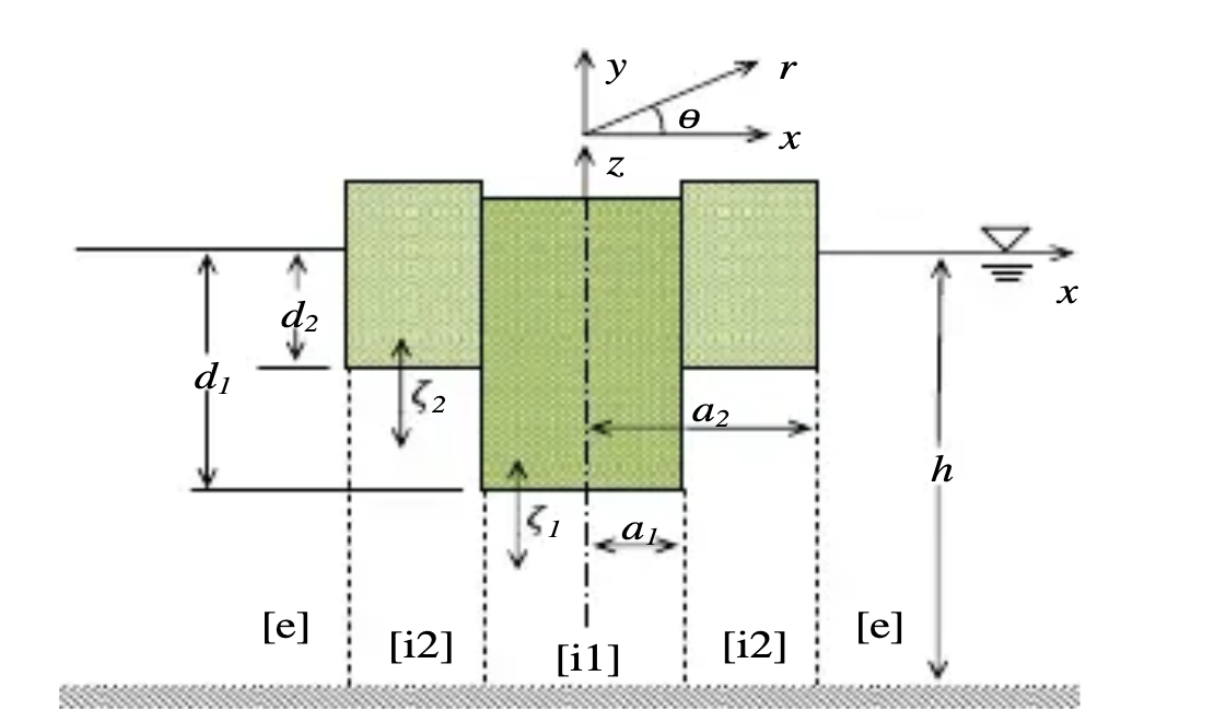

Set up a linear system to calculate the coefficients for each domain. $C_{1n} \text{ and } C_{2n}$

### Stuff needed to setup linear system. (N=1) used


In [65]:
import numpy as np
from scipy.special import iv as besseli
from scipy.special import kv as besselk
from scipy.special import hankel1 as besselh
from scipy import integrate  #uses gaussian quadrature method


#FIX constants here...mostly some ratio of h
h = 10
z,r = 0,3
a2 = 10
a1 = 5
m0 = 0.1
d1,d2 = 5,2.5

# equation 4 defining all the lambdas for each n1 and n2 boundaries
def lambda_n1(n,d1=1,h=10):
  return n*np.pi/(h-d1)

def lambda_n2(n,d2=1,h=10):
  return n*np.pi/(h-d2)


#equation 5 defining the particular solutions
def phi_p(d):
  return 1/(2*(h-d)) * ((z+h)**2 - (r**2)/2)

#define lambda func for phi_p_i1, phi_p_i2, phi_p_e for easy call using ph_p

phi_p_i1 = lambda d1: phi_p(d1)
phi_p_i2 =  lambda d2: phi_p(d2)


#differentiate with respect to r as that is needed down the road and the function for that is symbolically derived for matching velocity

def diff_phi_p_i2(h): #inputs d,z,r,h
  return r/(2*d2 - 2*h)

def diff_phi_p_i1_i2(x): #differentiation of difference of particular solution
  return r/(2*d1 - 2*h) - r/(2*d2 - 2*h)

#equation 7 defining the Rs: eigenfunctions ?
def R_1n_1(n):
  if n==0:
    return 1/2
  else:
    return besseli(0,lambda_n1(n)*r)/besseli(0,lambda_n1(n)*a2)

def diff_R_1n_1(n):
  if n == 0:
    result = 0
  else:
    numerator = n * np.pi * besseli(1,np.pi * n * r / (d1 - h))
    denominator = (d1 - h) * besseli(0,np.pi * a2 * n / (d1 - h))
    result = numerator / denominator
  return result  #symbolically get from matlab
#piecewise(n == 0, 0, 1 <= n, (n*pi*besseli(1, (pi*n*r)/(d1 - h)))/((d1 - h)*besseli(0, (pi*a2*n)/(d1 - h))))


def R_1n_2(n):
  if n==0:
    return 1/2
  else:
    return besseli(0,lambda_n2(n)*r)/besseli(0,lambda_n2(n)*a2)

def diff_R_1n_2(n):
  if n == 0:
    result = 0
  else: #n >= 1
    numerator = n * np.pi *  besseli(1,np.pi * n * r / (d2 - h))
    denominator = (d2 - h) * besseli(0,np.pi * a2 * n / (d2 - h))
    result = numerator / denominator
  return result
  #piecewise(n == 0, 0, 1 <= n, (n*pi*besseli(1, (pi*n*r)/(d2 - h)))/((d2 - h)*besseli(0, (pi*a2*n)/(d2 - h))))

#Similarly Equation 8  besselk

def R_2n_1(n):
  return 0.0



def diff_R_2n_1(n):
  return 0.0 #symbolically get from matlab

def R_2n_2(n):
  if n==0:
    return 1/2
  else:
    return besselk(0,lambda_n2(n)*r)/besselk(0,lambda_n2(n)*a2)

def diff_R_2n_2(n):
  if n == 0:
    result = 1 / (2 * r)
  else:
    numerator = n * np.pi * besselk(1,-(np.pi * n * r) / (d2 - h))
    denominator = (d2 - h) * besselk(0,-(np.pi * a2 * n) / (d2 - h))
    result = numerator / denominator
  return result #symbolically get from matlab
  #piecewise(n == 0, 1/(2*r), 1 <= n, (n*pi*besselk(1, -(pi*n*r)/(d2 - h)))/((d2 - h)*besselk(0, -(pi*a2*n)/(d2 - h))))


#Equation 9
def Z_n_i1(n):
  if n==0:
    return 1
  else:
    return np.sqrt(2)*np.cos(lambda_n1(n)*z+h)

def Z_n_i2(n):
  if n==0:
    return 1
  else:
    return np.sqrt(2)*np.cos(lambda_n2(n)*z+h)
#going back to equation 6
  #Inner product of Cs and Rs multiplied by Zs


#Equation 13 #needs to solve dispersion equation
def m_k(k):
  return 1 # return actual value by solving dispersion not 1

def Lambda_k(k):
  m0 = 0.1
  a2= 2
  r = 3
  if k==0:
    return besselh(0,1,m0*r)/besselh(0,1,m0*a2)
  else:
    return besselk(0,m_k(k)*r)/besselk(0,m_k(k)*a2)


def diff_Lambda_k(n):
  if n == 0:
    numerator = -(m0 * besselh(1, m0 * r))
    denominator = besselh(0, a2 * m0)
  else:
    numerator = -(m_k(n) * besselk(1,r * m_k(n)))
    denominator = besselk(0,a2 * m_k(n))
  return numerator/denominator
  #piecewise(n == 0, -(m0*besselh(1, 1, m0*r))/besselh(0, 1, a2*m0), 1 <= n, -(m_k(n)*besselk(1, r*m_k(n)))/besselk(0, a2*m_k(n)))

#% eq 2.34 in analytical methods book, also eq 16 in Seah and Yeung 2006

def N_k(k,h=1):
  if k==0:
    return 1/2*(1+np.sinh(2*m0*h)/(2*m0*h))
  else:
    return 1/2*(1+np.sin(2*m_k(k)*h)/(2*m_k(k)*h))

# Eq 14
def Z_n_e(k):
  if k==0:
    return 1/np.sqrt(N_k(k)) * np.cosh(m0*(z+h))
  else:
    return 1/2*(1+np.sin(2*m_k(k)*h)/(2*m_k(k)*h))





# more functions for exterior

#B_k are the unknown coefficients determined by matching boundary conditions r=a2

#Potential matching i.e linear system construction
#

#[Bu][L]-[Cu][R]=integrate phi_pi2 linear system bc 2.e
#[C1u][R]-[Cu][R] = integrate phi_p dot [Z]
#unknowns = [C_1n_1(0:N) C_1n_2(0:N) C_2n_2(0:N) B_n(0:N)];





Each of the potential matching is going to be a  part of linear system

** Boundary 2e potential** matching,

`$C_1n_2(n) * R_1n_2 + C_2n_2*R_2n_2 - B_n * Λ(n) =  - ∫ Φ_{p_i2} * Z_n_i2(n)$`

where C_1n_2 , C_2n_2 , B_n are unknown coefficients.


Boundary 2e velocity matching,

`C_1n_2(n) * R_1n_2 + C_2n_2*R_2n_2 - B_n * Λ(n) =  - ∫ Φ * Z_n_e(n)`




In [66]:
# Boundary 2e - unknowns [C_1n_1(0:N) C_1n_2(0:N) C_2n_2(0:N) B_n(0:N)];
coefs_2E = [0,R_1n_2(1),R_2n_2(1),-Lambda_k(1)] # for i in range(N) #R_1n_1 =0? add them later when setting up Matrix to invert
rhs_2E = -integrate.romberg(phi_p_i2, -h, -d2) * Z_n_i2(1)
# velocity matching boundary 2e--  MISSING DIFF of R_s
#
coefs_velocity_2E = [0,diff_R_1n_2(1),diff_R_2n_2(1),- diff_Lambda_k(1)] #R_1n_1= 0 for B_n as there is no B_n here
rhs_velocity_2E = -integrate.romberg(diff_phi_p_i2, -h, -d2) * Z_n_e(1)




Similarly Boundary 12 potential matching

`C_1n_2(n) * R_1n_2 + C_2n_2*R_2n_2 - C_1n_1*R_1n_1 =  - ∫ Φ_{12}-ϕ_{i1}* Z_n_i1(n)`

and similarly Boundary 12 velocity matching

`C_1n_2(n) * R_1n_2 + C_2n_2*R_2n_2  - C_1n_1*R_1n_1 =  - ∫ Φ_{12}-ϕ_{i1}* Z_n_i2(n)`

In [67]:
coefs_12 = [-R_1n_1(1),R_1n_2(1),R_2n_2(1),0] #Lambda_k = 0 for B_n as there is no B_n here
rhs_12 = -(integrate.romberg(phi_p_i1, -h, -d1) - integrate.romberg(phi_p_i2, -h, -d1)) * Z_n_i1(1)

#velocity matching - MISSING DIFF o R_s
coefs_velocity_12 = [-diff_R_1n_1(1),diff_R_1n_2(1),diff_R_2n_2(1),0] #Lambda_k = 0 for B_n as there is no B_n here
rhs_velocity_12 = -(integrate.romberg(diff_phi_p_i1_i2, -h, -d1)) * Z_n_i2(1)



In [68]:
coefs_velocity_2E

[0, 0.02393901751983227, -18.44448480111776, 2258.50902061684]

### Thoughts

- Now how to set up linear system so that we can do rhs/coefs for all

In [69]:
A = np.array([coefs_2E,coefs_velocity_2E,coefs_12,coefs_velocity_12])
A

array([[ 0.00000000e+00,  1.76700040e-01,  1.98769097e+01,
        -3.05016447e-01],
       [ 0.00000000e+00,  2.39390175e-02, -1.84444848e+01,
         2.25850902e+03],
       [-1.76700040e-01,  1.76700040e-01,  1.98769097e+01,
         0.00000000e+00],
       [-1.02990062e-02,  2.39390175e-02, -1.84444848e+01,
         0.00000000e+00]])

In [70]:
B = np.array([rhs_2E,rhs_velocity_2E,rhs_12,rhs_velocity_12]).transpose()
B

array([26.63106719, -0.71858767,  0.        , -0.59331317])

The unknown coefficients are $X = A^{-1}B$

In [71]:
X = np.linalg.solve(A,B)

These are the value of unknown coefficients. $C^{q}_{1n}$s and $B_n$s

In [72]:
X

array([ 1.50712137e+02,  1.36614453e+02,  1.25324385e-01, -7.42728820e-04])